In [3]:
import zipfile
import joblib
import yaml
import io
from pathlib import Path

class ScalingZipLoader:
    def __init__(self, zip_path):
        self.zip_path = Path(zip_path)
        if not self.zip_path.exists():
            raise FileNotFoundError(f"❌ ไม่พบไฟล์ ZIP: {zip_path}")

        self.scaler_in = None
        self.scaler_out = None
        self.metadata = None

    def load(self):
        """โหลด input/output scaler และ metadata จาก ZIP"""
        with zipfile.ZipFile(self.zip_path, "r") as zipf:
            # ✅ โหลด input_scaler.pkl
            with zipf.open("input_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_in = joblib.load(buffer)

            # ✅ โหลด output_scaler.pkl
            with zipf.open("output_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_out = joblib.load(buffer)

            # ✅ โหลด metadata.yaml
            with zipf.open("metadata.yaml") as f:
                self.metadata = yaml.safe_load(f)

        print(f"📦 Loaded ZIP successfully: {self.zip_path}")
        return self.scaler_in, self.scaler_out, self.metadata


if __name__ == "__main__":
    # 🧪 ตัวอย่างการใช้งาน
    zip_file = r"D:\Project_end\New_world\my_project\config\RC_Tank_Env_Training2_scalers.zip"
    loader = ScalingZipLoader(zip_file)
    scaler_in, scaler_out, metadata = loader.load()

    print("\n🎯 Metadata summary:")
    print(yaml.dump(metadata, allow_unicode=True, sort_keys=False))

    # ✅ ตัวอย่างการใช้งาน scaler
    import numpy as np
    sample_input = np.array([[0.5]])
    scaled_input = scaler_in.transform(sample_input)
    print("\nSample input 0.5 scaled:", scaled_input)


FileNotFoundError: ❌ ไม่พบไฟล์ ZIP: D:\Project_end\New_world\my_project\config\RC_Tank_Env_Training2_scalers.zip

Epoch 1/50, Loss: 0.177531
Epoch 5/50, Loss: 0.061274
Epoch 10/50, Loss: 0.025124
Epoch 15/50, Loss: 0.006801
Epoch 20/50, Loss: 0.002583
Epoch 25/50, Loss: 0.001128
Epoch 30/50, Loss: 0.000525
Epoch 35/50, Loss: 0.000275
Epoch 40/50, Loss: 0.000188
Epoch 45/50, Loss: 0.000155
Epoch 50/50, Loss: 0.000133


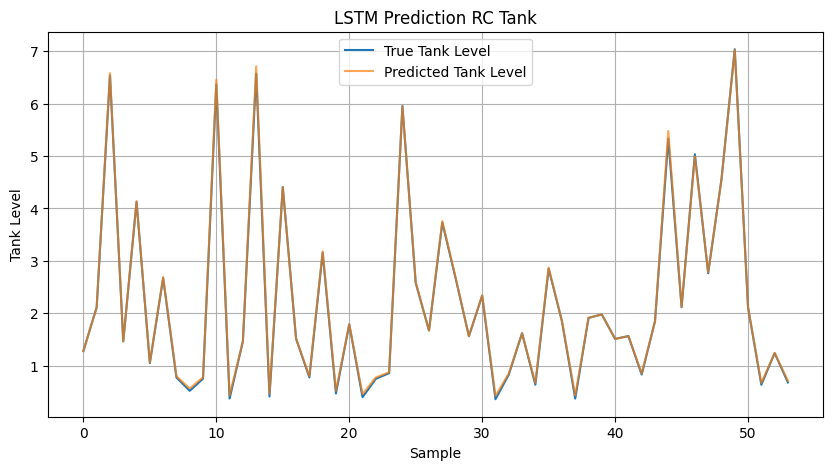

In [ ]:
# -----------------------------
# LSTM RC Tank Prediction Example
# -----------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# -----------------------------
# Load dataset
# -----------------------------
data_file = r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.10_freq_0.10_pwm.csv"
df = pd.read_csv(data_file)

# -----------------------------
# Load scalers (จาก ZIP ก็ได้)
# -----------------------------
# ตัวอย่างใช้ MinMaxScaler ใหม่
input_features = ["DATA_INPUT", "DATA_OUTPUT"]
output_features = ["DATA_OUTPUT"]

scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()

X_scaled = scaler_in.fit_transform(df[input_features].values)
y_scaled = scaler_out.fit_transform(df[output_features].values)

# -----------------------------
# สร้าง sequences สำหรับ LSTM
# -----------------------------
window_size = 30

def create_sequences(X, y, window_size=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size=window_size)

# แบ่ง train/val/test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# แปลงเป็น torch.Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# -----------------------------
# สร้าง LSTM model
# -----------------------------
class LSTM_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

model = LSTM_Predictor(input_size=input_size, hidden_size=64, num_layers=2, output_size=output_size)

# -----------------------------
# Training setup
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
batch_size = 64

# -----------------------------
# Training loop
# -----------------------------
for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))
    epoch_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= X_train.size(0)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

# -----------------------------
# Test & Plot
# -----------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# แปลงกลับ scale เดิม
y_pred_orig = scaler_out.inverse_transform(y_pred)
y_test_orig = scaler_out.inverse_transform(y_test.numpy())

plt.figure(figsize=(10,5))
plt.plot(y_test_orig, label="True Tank Level")
plt.plot(y_pred_orig, label="Predicted Tank Level", alpha=0.7)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Tank Level")
plt.title("LSTM Prediction RC Tank")
plt.grid(True)
plt.show()


In [ ]:
import sys
from pathlib import Path

# project_root = my_project
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("✅ Project root added to sys.path:", project_root)

✅ Project root added to sys.path: D:\Project_end\New_world\my_project


In [ ]:
import src.models.lstm_model
print(dir(src.models.lstm_model))

['LSTMForecaster', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nn', 'torch']


In [ ]:
%run setup_path.py

import torch
from src.data.scaling_loader import ScalingZipLoader
from src.data.sequence_builder import create_sequences
from src.models.lstm_model import LSTM_MODEL
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from src.utils.logger import Logger
import pandas as pd



# ===========================
# 1️⃣ Configuration
# ===========================
DATA_FILE = Path(r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.10_freq_0.10_pwm.csv")
SCALER_ZIP = Path(r"D:\Project_end\New_world\my_project\config\RC_Tank_Env_Training2_scalers.zip")
WINDOW_SIZE = 10
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===========================
# 2️⃣ Load data
# ===========================
df = pd.read_csv(DATA_FILE)
X_raw = df[["DATA_INPUT"]].values
y_raw = df[["DATA_OUTPUT"]].values

# ===========================
# 3️⃣ Load scalers
# ===========================
scaler_loader = ScalingZipLoader(SCALER_ZIP)
X_scaled = scaler_loader.transform_input(X_raw)
y_scaled = scaler_loader.inverse_output(y_raw)  # หรือ transform_output ถ้ามี

# ===========================
# 4️⃣ Create sequences
# ===========================
X_seq, y_seq = create_sequences(np.column_stack((X_scaled, y_scaled)), window_size=WINDOW_SIZE)

# ===========================
# 5️⃣ Train/Val split
# ===========================
dataset = TensorDataset(torch.tensor(X_seq, dtype=torch.float32),
                        torch.tensor(y_seq, dtype=torch.float32))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===========================
# 6️⃣ Model & Optimizer
# ===========================
input_dim = X_seq.shape[2]
model = LSTM_MODEL(input_dim=input_dim, hidden_dim=64, output_dim=1, stateful=False).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ===========================
# 7️⃣ Logger
# ===========================
logger = Logger()

# ===========================
# 8️⃣ Training Loop
# ===========================
for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).unsqueeze(-1)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).unsqueeze(-1)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    # Log
    logger.add_data_log(["epoch", "train_loss", "val_loss"], [[epoch], [epoch_loss], [val_loss]])
    print(f"Epoch {epoch:03d} | Train Loss: {epoch_loss:.6f} | Val Loss: {val_loss:.6f}")

# ===========================
# 9️⃣ Save trained model
# ===========================
MODEL_PATH = Path("D:/Project_end/New_world/my_project/models/lstm_model.pth")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved at {MODEL_PATH}")

# ===========================
# 10️⃣ Save training log
# ===========================
logger.save_to_csv("training_log", folder_name="logs")
print("✅ Training log saved")


Epoch 001 | Train Loss: 5375.813965 | Val Loss: 3635.855385
Epoch 002 | Train Loss: 5143.174375 | Val Loss: 3420.062045
Epoch 003 | Train Loss: 4902.514371 | Val Loss: 3243.886323
Epoch 004 | Train Loss: 4707.832654 | Val Loss: 3120.689950
Epoch 005 | Train Loss: 4574.509252 | Val Loss: 3020.892940
Epoch 006 | Train Loss: 4456.132025 | Val Loss: 2935.719743
Epoch 007 | Train Loss: 4350.437374 | Val Loss: 2857.405038
Epoch 008 | Train Loss: 4249.118787 | Val Loss: 2780.933072
Epoch 009 | Train Loss: 4151.508402 | Val Loss: 2710.562424
Epoch 010 | Train Loss: 4063.609573 | Val Loss: 2640.454186
Epoch 011 | Train Loss: 3974.747845 | Val Loss: 2577.258478
Epoch 012 | Train Loss: 3893.360482 | Val Loss: 2514.562391
Epoch 013 | Train Loss: 3811.751174 | Val Loss: 2458.252837
Epoch 014 | Train Loss: 3736.406629 | Val Loss: 2404.463648
Epoch 015 | Train Loss: 3666.089852 | Val Loss: 2349.791967
Epoch 016 | Train Loss: 3594.580533 | Val Loss: 2299.194041
Epoch 017 | Train Loss: 3526.368290 | Va

In [25]:
def suggest_chunksize(seq_len, multiplier_range=(3, 10)):
    min_chunksize = seq_len + 1
    recommended_min = seq_len * multiplier_range[0]
    recommended_max = seq_len * multiplier_range[1]
    
    return {
        'min_chunksize': min_chunksize,
        'recommended_range': (recommended_min, recommended_max)
    }

seq_len = 50
chunksize_info = suggest_chunksize(seq_len)
print(chunksize_info)

{'min_chunksize': 51, 'recommended_range': (150, 500)}


In [28]:
%run setup_path.py
from src.data.scaling_loader import ScalingZipLoader
from src.data.sequence_builder import create_sequences
from src.models.lstm_model import LSTM_MODEL
from torch.utils.data import DataLoader, TensorDataset, random_split
from src.utils.logger import Logger
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os

# LOAD SCALE
PATH_FILE_SCALE = r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip"
Path_FILE_DATA = Path(r"D:\Project_end\New_world\my_project\data\raw")
scale_loader = ScalingZipLoader(Path(PATH_FILE_SCALE))
#scale_loader.summary()
print(f"INPUT SCALE --> MIN: {scale_loader.scaler_in.data_min_.tolist()} | MAX: {scale_loader.scaler_in.data_max_.tolist()}")
print(f"OUTPUT SCALE --> MIN: {scale_loader.scaler_out.data_min_.tolist()} | MAX: {scale_loader.scaler_out.data_max_.tolist()}")
csv_files = sorted(list(Path_FILE_DATA.glob("*.csv")))


class SequenceDataset(Dataset):

    def __init__(self, folder_path, scale_path, sequence_size,
                 input_col='DATA_INPUT', output_col='DATA_OUTPUT', 
                 file_ext='.csv', chunksize=1000):
        

        self.folder_path = Path(folder_path)
        self.scale_path = Path(scale_path)
        self.sequence_size = sequence_size
        self.input_col = input_col
        self.output_col = output_col
        self.file_ext = file_ext
        self.chunksize = chunksize

        
        self.scaling_loader = ScalingZipLoader(self.scale_path)
        self.scaler_input = self.scaling_loader.scaler_in  
        self.scaler_output = self.scaling_loader.scaler_out

        
        self.X, self.y = self.load_and_create_sequences(folder_path, file_ext)

    def load_and_create_sequences(self, folder_path, file_ext):
        X_all, y_all = [], []
        files = [f for f in os.listdir(folder_path) if f.endswith(file_ext)]

        for file_name in files:
            file_path = os.path.join(folder_path, file_name)

            for chunk in pd.read_csv(file_path, chunksize=self.chunksize):
                # scale input/output
                inputs = self.scaler_input.transform(chunk[self.input_col].values)
                outputs = self.scaler_output.transform(chunk[self.output_col].values)

                X_seq, y_seq = self.create_sequences(inputs, outputs)

                if len(X_seq) > 0:
                    X_all.append(X_seq)
                    y_all.append(y_seq)

        return np.vstack(X_all), np.vstack(y_all)


    def create_sequences(self, X_data, y_data):
        Xs, ys = [], []
        for i in range(len(X_data) - self.sequence_size):  # ใช้ sequence_size ตามชื่อเดิม
            Xs.append(X_data[i:i + self.sequence_size])
            ys.append(y_data[i + self.sequence_size])
        return np.array(Xs), np.array(ys)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



FOLDER_FILE = r"D:\Project_end\New_world\my_project\data\raw"
PATH_SCALE = r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip"

dataset = SequenceDataset(
    folder_path=FOLDER_FILE,
    scale_path=PATH_SCALE,
    sequence_size=11,
    input_col=['DATA_INPUT'],
    output_col=["DATA_OUTPUT"],
    chunksize=1000
)

X, y = dataset[0]
print(f"X shape:{X.shape} | y shape:{y.shape} | dataset:{len(dataset)} row")
print(y)



✅ Successfully loaded artifacts from: Test_scale1_scalers.zip
INPUT SCALE --> MIN: [0.0] | MAX: [24.0]
OUTPUT SCALE --> MIN: [1.389728099221949e-06] | MAX: [23.9999986102719]
✅ Successfully loaded artifacts from: Test_scale1_scalers.zip
X shape:(11, 1) | y shape:(1,) | dataset:39560 row
[0.30969242]
